In [216]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import numpy as np
import os 
import nibabel as nib
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nilearn import plotting
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from scipy import stats
from scipy.ndimage.measurements import center_of_mass
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
#import brainiak.utils.fmrisim as sim
#from brainiak.fcma.util import compute_correlation
from nilearn import input_data
import time
#from utils import shift_timing

%autosave 5
%matplotlib inline
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


In [184]:
datadir='/home/data/refined/microbiome2brain/MRI/bids_dataset'
from bids.grabbids import BIDSLayout
layout = BIDSLayout(datadir)

In [3]:
source_epi = layout.get(type="bold", task="rest", session="01", extensions="nii.gz")[0]
source_epi.subject

'E1'

# Seed-to-voxel connectivity analysis using residualized image from xcpOutput

## Mask and extract the whole-brain data

Atlas path: /home/vanessa.d/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-2mm.nii.gz


Harvard-Oxford subcortical atlas


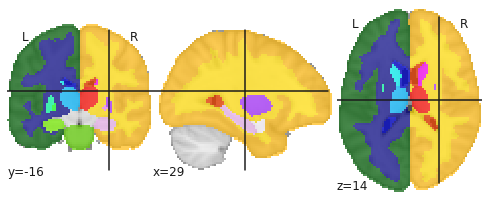

In [185]:
atlas = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')
atlas_filename = atlas.maps

# This is where the atlas is saved.
print("Atlas path: " + atlas_filename + "\n\n")

# Plot the ROIs
plotting.plot_roi(atlas_filename);
print('Harvard-Oxford subcortical atlas')


In [186]:
# Print the labels
# Label 0 (Background) refers to the brain image, not background connectivity

# Create a Pandas dataframe of the atlas data for easy inspection.
atlas_pd = pd.DataFrame(atlas)
print(atlas_pd['labels'])

0                      Background
1      Left Cerebral White Matter
2           Left Cerebral Cortex 
3          Left Lateral Ventrical
4                   Left Thalamus
5                    Left Caudate
6                    Left Putamen
7                   Left Pallidum
8                      Brain-Stem
9                Left Hippocampus
10                  Left Amygdala
11                 Left Accumbens
12    Right Cerebral White Matter
13         Right Cerebral Cortex 
14        Right Lateral Ventricle
15                 Right Thalamus
16                  Right Caudate
17                  Right Putamen
18                 Right Pallidum
19              Right Hippocampus
20                 Right Amygdala
21                Right Accumbens
Name: labels, dtype: object


In [213]:
# Init a masker object that also standardizes the data
masker_wb = input_data.NiftiMasker(
    standardize=True,  # Are you going to zscore the data across time?
    #t_r=2, 
    #detrend=True,
    #smoothing_fwhm=8,
    #low_pass=0.09, high_pass=0.008,
    memory='nilearn_cache',  # Caches the mask in the directory given as a string here so that it is easier to load and retrieve
    memory_level=1,  # How much memory will you cache?
    verbose=0
)

# Create a masker object that we can use to select ROIs
masker_ho = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize=True,  # Are you going to zscore the data across time?
    #t_r=2, 
    #detrend=True,
    #smoothing_fwhm=8,
    #low_pass=0.09, high_pass=0.008,
    memory='nilearn_cache',  # Caches the mask in the directory given as a string here so that it is easier to load and retrieve
    memory_level=1,  # How much memory will you cache?
    verbose=0
)
print(masker_ho.get_params())


{'background_label': 0, 'detrend': False, 'dtype': None, 'high_pass': None, 'high_variance_confounds': False, 'labels_img': '/home/vanessa.d/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-2mm.nii.gz', 'low_pass': None, 'mask_img': None, 'memory': 'nilearn_cache', 'memory_level': 1, 'resampling_target': 'data', 'smoothing_fwhm': None, 'standardize': True, 'standardize_confounds': True, 'strategy': 'mean', 't_r': None, 'verbose': 0}


In [217]:
def seed_correlation(wbBold, seedBold):
    """Compute the correlation between a seed voxel vs. other voxels 
    Parameters
    ----------
    wbBold [2d array], n_stimuli x n_voxels 
    seedBold, 2d array, n_stimuli x 1

    Return
    ----------    
    seed_corr [2d array], n_stimuli x 1
    seed_corr_fishZ [2d array], n_stimuli x 1
    """
    num_voxels = wbBold.shape[1]
    seed_corr = np.zeros((num_voxels, 1))
    for v in range(num_voxels):    
        seed_corr[v, 0] = np.corrcoef(seedBold.flatten(), wbBold[:, v])[0, 1]
    # Transfrom the correlation values to Fisher z-scores    
    seed_corr_fishZ = np.arctanh(seed_corr)
    return seed_corr, seed_corr_fishZ

In [192]:
corr_RHC = {}
corr_fz_RHC = {}
conn_RHC = {}

for i in range(7):
    source_epi = layout.get(type="bold", task="image", session="01", extensions="nii.gz")[i]
    in_file=os.path.join(datadir, "derivatives", "xcpOutput",
                         "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session,"run-1",
                         "regress",
                         "sub-%s_ses-%s_run-1_residualised.nii.gz"%(source_epi.subject,source_epi.session))
    
    bold_wb = masker_wb.fit_transform(in_file)
    bold_ho = masker_ho.fit_transform(in_file)
    bold_ho_RHC = np.array(bold_ho[:, 18])
    bold_ho_RHC = bold_ho_RHC.reshape(bold_ho_RHC.shape[0],-1)
  
    corr_RHC[i], corr_fz_RHC[i] = seed_correlation(bold_wb, bold_ho_RHC)
    
    conn_RHC[i] = sum(corr_fz_RHC[i][corr_fz_RHC[i] > 0.25])
    
print(conn_RHC)


{0: 16145.861105353557, 1: 9521.933573200582, 2: 18308.595901121884, 3: 11115.318412424778, 4: 9833.61895292462, 5: 15984.218492556474, 6: 24063.21942978024}


In [191]:
corr_e1a = corr_RHC[0]

print(sum(corr_e1a[corr_e1a > 0.25]))

14552.191684737129


In [98]:
all_conn_ses01 = np.concatenate((conn_RHC[0], conn_RHC[1], conn_RHC[2], conn_RHC[3], 
                            conn_RHC[4], conn_RHC[5], conn_RHC[6]), axis=None)
print(all_conn_ses01)

[47313 61440 60413 34136 37090 42538 58715]


In [194]:
corr_RHC2 = {}
corr_fz_RHC2 = {}
conn_RHC2 = {}

for i in range(7):
    source_epi = layout.get(type="bold", task="image", session="02", extensions="nii.gz")[i]
    in_file=os.path.join(datadir, "derivatives", "xcpOutput",
                         "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session,"run-1",
                         "regress",
                         "sub-%s_ses-%s_run-1_residualised.nii.gz"%(source_epi.subject,source_epi.session))
    bold_wb2 = masker_wb.fit_transform(in_file)
    bold_ho2 = masker_ho.fit_transform(in_file)
    bold_ho_RHC2 = np.array(bold_ho2[:, 18])
    bold_ho_RHC2 = bold_ho_RHC.reshape(bold_ho_RHC2.shape[0],-1)
  
    corr_RHC2[i], corr_fz_RHC2[i] = seed_correlation(bold_wb2, bold_ho_RHC2)
    
    conn_RHC2[i] = sum(corr_RHC2[i][corr_RHC2[i] > 0.25])
    
print(conn_RHC2)

{0: 168.54856115608843, 1: 165.5080864906049, 2: 831.0349239275387, 3: 114.55080972322902, 4: 478.61456399689763, 5: 19.850582638829916, 6: 109.86259214371638}


In [218]:
i=0
source_epi = layout.get(type="bold", task="image", session="01", extensions="nii.gz")[i]
in_file=os.path.join(datadir, "derivatives", "xcpOutput_acompcor",
                         "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session,"run-1",
                         "regress",
                         "sub-%s_ses-%s_run-1_img_sm6.nii.gz"%(source_epi.subject,source_epi.session))
bold_wb2 = masker_wb.fit_transform(in_file)
bold_ho2 = masker_ho.fit_transform(in_file)
bold_ho_RHC2 = np.array(bold_ho2[:, 18])
bold_ho_RHC2 = bold_ho_RHC.reshape(bold_ho_RHC2.shape[0],-1)
  
corr_RHC2[i], corr_fz_RHC2[i] = seed_correlation(bold_wb2, bold_ho_RHC2)

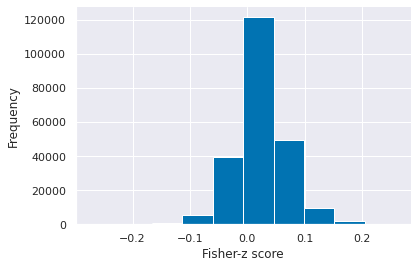

In [219]:
plt.hist(corr_RHC2[0])
plt.ylabel('Frequency');
plt.xlabel('Fisher-z score');
sns.despine()

In [200]:
all_conn_ses02 = np.concatenate((conn_RHC2[0], conn_RHC2[1], conn_RHC2[2], conn_RHC2[3], 
                            conn_RHC2[4], conn_RHC2[5], conn_RHC2[6]), axis=None)
print(all_conn_ses02)

[  0.         165.50808649 831.03492393 114.55080972 478.614564
  19.85058264 109.86259214]


In [ ]:
all_conn = np.concatenate(all_conn_ses01, all_conn_ses02, axis = 0)
all_conn
numpy.savetxt("output/conn_RHC.csv", all_conn, delimiter=",")

In [ ]:
source_epi = layout.get(type="bold", task="image", session="02", extensions="nii.gz")[0]
in_file=os.path.join(datadir, "derivatives", "xcpOutput",
                         "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session,"run-1",
                         "regress",
                         "sub-%s_ses-%s_run-1_residualised.nii.gz"%(source_epi.subject,source_epi.session))
bold_wb2 = masker_wb.fit_transform(in_file)
bold_ho2 = masker_ho.fit_transform(in_file)
bold_ho_RHC2 = np.array(bold_ho2[:, 19])
bold_ho_RHC2 = bold_ho_RHC.reshape(bold_ho_RHC2.shape[0],-1)
  
corr_RHC2, corr_fz_RHC2 = seed_correlation(bold_wb2, bold_ho_RHC2)
    
conn_RHC2 = sum(abs(corr_fz_RHC2) > 0.25)

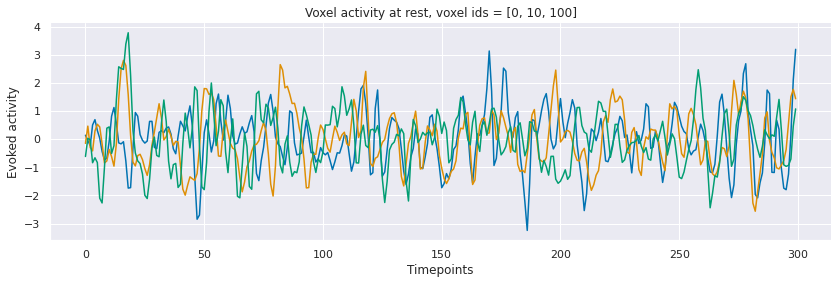

In [7]:
"""
Plot the timeseries for a few voxels
"""
voxel_ids = [0,10,100]

plt.figure(figsize=(14, 4))
plt.title('Voxel activity at rest, voxel ids = ' + str(voxel_ids));
plt.plot(bold_wb[:, voxel_ids]);
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');
sns.despine()

## create spherical seed ROI and extract signal

In [8]:
coords_RHC = [(26, -18, 16)]
masker_RHC = input_data.NiftiSpheresMasker(
    coords_RHC, 
    radius=8, standardize=True, t_r=2.,
    memory='nilearn_cache', memory_level=1, verbose=0
)

# Mask the epi data and get a time series for the ROI
bold_RHC_E1A = masker_RHC.fit_transform(res1[0])
bold_RHC_E2A = masker_RHC.fit_transform(res2[0])

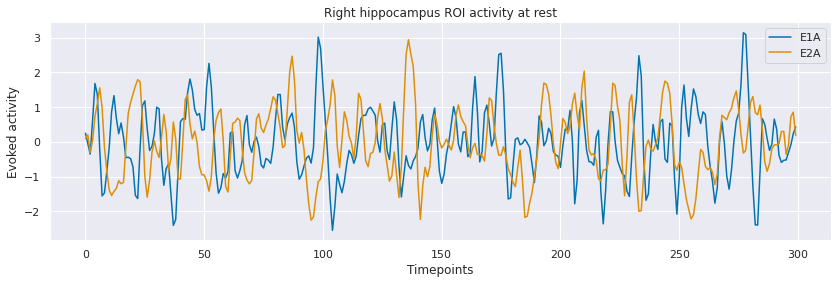

In [9]:
plt.figure(figsize=(14, 4))
plt.title('Right hippocampus ROI activity at rest')
plt.plot(bold_RHC_E1A);
plt.plot(bold_RHC_E2A);
plt.legend(('E1A', 'E2A'));
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');
sns.despine()

## compute the correlation matrix

In [10]:
def seed_correlation(wbBold, seedBold):
    """Compute the correlation between a seed voxel vs. other voxels 
    Parameters
    ----------
    wbBold [2d array], n_stimuli x n_voxels 
    seedBold, 2d array, n_stimuli x 1

    Return
    ----------    
    seed_corr [2d array], n_stimuli x 1
    seed_corr_fishZ [2d array], n_stimuli x 1
    """
    num_voxels = wbBold.shape[1]
    seed_corr = np.zeros((num_voxels, 1))
    for v in range(num_voxels):    
        seed_corr[v, 0] = np.corrcoef(seedBold.flatten(), wbBold[:, v])[0, 1]
    # Transfrom the correlation values to Fisher z-scores    
    seed_corr_fishZ = np.arctanh(seed_corr)
    return seed_corr, seed_corr_fishZ

Seed-based correlation Fisher-z transformed: min = -0.492; max = 0.624


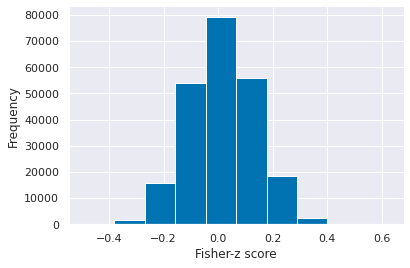

In [11]:
# Let's use the function and print out the range of results
corr_RHC, corr_fz_RHC = seed_correlation(bold_wb, bold_RHC_E1A)
print("Seed-based correlation Fisher-z transformed: min = %.3f; max = %.3f" % (
    corr_fz_RHC.min(), corr_fz_RHC.max()
))


# A histogram is always a useful first way of looking at your data.
plt.hist(corr_fz_RHC)
plt.ylabel('Frequency');
plt.xlabel('Fisher-z score');
sns.despine()


In [21]:
print(corr_fz_RHC.shape)
conn = corr_fz_RHC[abs(corr_fz_RHC) > 0.25]
conn.shape
sum(abs(corr_fz_RHC) > 0.25)


AttributeError: 'dict' object has no attribute 'shape'

In [24]:
print(corr_fz_RHC[0].shape)
conn = corr_fz_RHC[0][abs(corr_fz_RHC[0]) > 0.25]
type(conn)
total_conn = sum(abs(corr_fz_RHC[0]) > 0.25)
type(total_conn)

(227901, 1)


numpy.ndarray

In [14]:
# We can tranform the correlation array back to a Nifti image object that we can save
img_corr_RHC= masker_wb.inverse_transform(corr_fz_RHC.T)
img_corr_RHC.to_filename(os.path.join(datadir, "derivatives", "rsConn",'sub-E1A_ses-01_run-1_RHCcorr.nii.gz'))

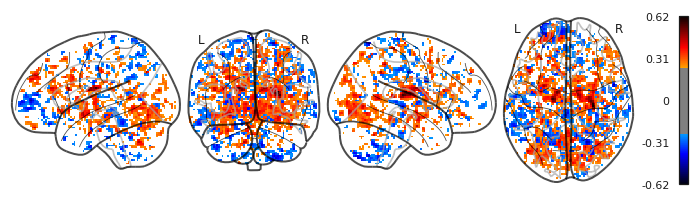

In [15]:
threshold = 0.25
plotting.plot_glass_brain(
    img_corr_RHC, 
    threshold=threshold,
    colorbar=True, 
    plot_abs=False,
    display_mode='lyrz', 
)